In [58]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seawater as sw #import gsw

In [64]:
90*365/60/60

9.125

In [2]:
# location of input data
data_path = '/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/'
experiment_name = 'INALT20.L46-KFS119' 
data_resolution = '1d'

# location of mask data
mask_path = data_path
mesh_mask_filename = '1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc'

# names of files to load
fname_T = f'1_{experiment_name}_{data_resolution}_2009*_grid_T_iMirabilis.nc'

#ROMS
ROMS_path = f'/gxfs_work1/geomar/smomw523/master-thesis/data/config/ROMS/roms_avg*_2009_datetime.nc'
ROMSchild_path = f'/gxfs_work1/geomar/smomw523/master-thesis/data/config/ROMS/roms_avg*_2009_datetime.nc.1'

depthpath_ROMS = '/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/ROMS/sigma2depth_parent.nc'
depthpath_ROMSchild = '/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/ROMS/sigma2depth_child.nc'

In [43]:
MLD_Franziska = xr.open_dataset('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/MLD/1_INALT20.L46-KFS119_1d_20090101_20091231_MLD_iMirabilis.nc')
MLD_Franziska_sliced = MLD_Franziska.somxl010.where((MLD_Franziska.somxl010.x==165) & (MLD_Franziska.somxl010.y==295),drop=True).compute()

In [3]:
T = xr.open_mfdataset(data_path+experiment_name+'/'+fname_T)
T_ROMS = xr.open_mfdataset(ROMS_path)
T_ROMSchild = xr.open_mfdataset(ROMSchild_path)

depth_ROMS = xr.open_dataset(depthpath_ROMS)
depth_ROMSchild = xr.open_dataset(depthpath_ROMSchild)

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [5]:
# to find indices of Ewing tip

lons_INALT = np.linspace(0,18.05,362)
lats_INALT = np.linspace(-36.01364,-17.949007,409)
lons_ROMS = np.linspace(6.51,9.995295,238)
lats_ROMS = np.linspace(-24.96,-21.487732,258)
lons_ROMSchild = np.linspace(7.5590196,8.858039,266)
lats_ROMSchild = np.linspace(-23.870966,-22.677746,266)
print("INALT")
print("Lon index of Ewing is: ", np.where(lons_INALT == find_nearest(lons_INALT, 8.25))[0])
print("Lat index of Ewing is: ", np.where(lats_INALT == find_nearest(lats_INALT, -23.2))[0])
print("ROMS")
print("Lon index of Ewing is: ", np.where(lons_ROMS == find_nearest(lons_ROMS, 8.25))[0])
print("Lat index of Ewing is: ", np.where(lats_ROMS == find_nearest(lats_ROMS, -23.2))[0])
print("ROMS")
print("Lon index of Ewing is: ", np.where(lons_ROMSchild == find_nearest(lons_ROMSchild, 8.25))[0])
print("Lat index of Ewing is: ", np.where(lats_ROMSchild == find_nearest(lats_ROMSchild, -23.2))[0])

INALT
Lon index of Ewing is:  [165]
Lat index of Ewing is:  [289]
ROMS
Lon index of Ewing is:  [118]
Lat index of Ewing is:  [130]
ROMS
Lon index of Ewing is:  [141]
Lat index of Ewing is:  [149]


In [9]:
# sigma levels to meters
Ewing_ROMS = depth_ROMS.hs.isel(lat_rho = 130, lon_rho = 118)
Ewing_ROMSchild = depth_ROMSchild.hs.isel(lat_rho = 149, lon_rho = 141)

# Density

In [23]:
%%time

#limit to area around Ewing (if only one location is chosen, the calculation in wayyyyy faster)
sliced = T.isel(x = 165, y=295).compute()
sliced_ROMS = T_ROMS.isel(xi_rho=118,eta_rho=130).compute()
sliced_ROMSchild = T_ROMSchild.isel(xi_rho=141,eta_rho=149).compute()

CPU times: user 1min 1s, sys: 11.7 s, total: 1min 12s
Wall time: 1min 28s


In [33]:
%%time

# EOS80 density https://pythonhosted.org/seawater/eos80.html

sigma = xr.DataArray(sw.pden(sliced.vosaline,
                             sliced.votemper,
                             sliced.deptht,
                            )-1000, dims=('time_counter', 'deptht')).compute()
sigma = sigma.assign_coords(time_counter=sliced.time_counter, deptht=sliced.deptht.to_numpy())

sigma_ROMS = xr.DataArray(sw.pden(sliced_ROMS.salt,
                             sliced_ROMS.temp,
                             Ewing_ROMS,
                            )-1000, dims=('time', 's_rho')).compute()
sigma_ROMS = sigma_ROMS.assign_coords(time=sliced_ROMS.time,s_rho=Ewing_ROMS.to_numpy())

sigma_ROMSchild = xr.DataArray(sw.pden(sliced_ROMSchild.salt,
                             sliced_ROMSchild.temp,
                             Ewing_ROMSchild,
                            )-1000, dims=('time', 's_rho')).compute()
sigma_ROMSchild = sigma_ROMSchild.assign_coords(time=sliced_ROMSchild.time, s_rho=Ewing_ROMSchild.to_numpy())

CPU times: user 6.91 ms, sys: 2.01 ms, total: 8.91 ms
Wall time: 7.92 ms


In [35]:
%%time

# determine mixed layer depths...
MLD_INALT_s, MLD_ROMS_s, MLD_ROMSchild_s = [],[],[]

for i in np.arange(365): #...for each day
    sigma.isel(time_counter=i).plot() #plot density
    sigma_ROMS.isel(time=i).plot()        
    sigma_ROMSchild.isel(time=i).plot()   
        
        
    threshold1_s = sigma.isel(time_counter=i).sel(deptht = 10, method = 'nearest')+.01 #get density threshold (10m density +.1 dsigma)
    threshold2_s = sigma_ROMS.isel(time=i).sel(s_rho = 10, method= 'nearest')+.01
    threshold3_s = sigma_ROMSchild.isel(time=i).sel(s_rho = 10, method= 'nearest')+.01
    
    lines = plt.gca().get_lines() #get lines of plot
    x_data1 = lines[0].get_xdata() #...
    y_data1 = lines[0].get_ydata() #...
    x_data2 = np.flip(lines[1].get_xdata())
    y_data2 = np.flip(lines[1].get_ydata())
    x_data3 = np.flip(lines[2].get_xdata())
    y_data3 = np.flip(lines[2].get_ydata())
    
    intersec_INALT = None
    intersec_ROMS = None        
    intersec_ROMSchild = None    
    
    for i in range(len(x_data1)):
        if y_data1[i] > threshold1_s and intersec_INALT is None:
            intersec_INALT = x_data1[i]
            
    for i in range(len(x_data2)):
        if y_data2[i] > threshold2_s and intersec_ROMS is None:
            intersec_ROMS = x_data2[i]
            
    for i in range(len(x_data3)):
        if y_data3[i] > threshold3_s and intersec_ROMSchild is None:
            intersec_ROMSchild = x_data3[i]
        
    MLD_INALT_s.append(intersec_INALT)
    MLD_ROMS_s.append(intersec_ROMS)
    MLD_ROMSchild_s.append(intersec_ROMSchild)
    plt.close()

CPU times: user 17.9 s, sys: 272 ms, total: 18.2 s
Wall time: 18.3 s


In [38]:
data = {'INALT': MLD_INALT_s,'ROMS': MLD_ROMS_s, 'ROMSchild': MLD_ROMSchild_s}
MLD_s = pd.DataFrame(data,index=pd.date_range(start='2009-01-01', end='2009-12-31'))

In [39]:
MLD_s.to_csv(f'/gxfs_work1/geomar/smomw523/master-thesis/output_data/retention/MLD2009_s001_EOS80_oneloc.csv')

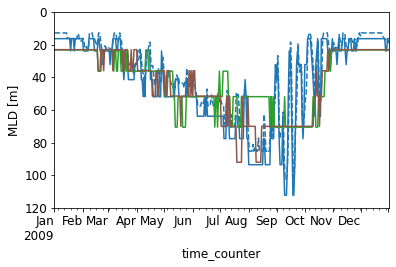

In [55]:
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Arial'

MLD_s['INALT'].plot(color='tab:blue')
MLD_Franziska_sliced.squeeze().to_pandas().plot(color='tab:blue',linestyle='--') #.resample(time_counter='1M').mean()
MLD_s['ROMS'].plot(color='tab:green')
MLD_s['ROMSchild'].plot(color='tab:brown')
plt.ylabel('MLD [m]')
plt.ylim([0,120])
plt.gca().invert_yaxis();

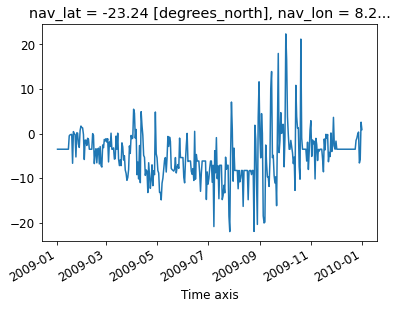

In [51]:
(MLD_Franziska_sliced.squeeze()-MLD_s['INALT']).plot()